In [1]:
#libraries
import pandas as pd
import json      # library for working with JSON-formatted text strings
import requests  # library for accessing content from web URLs
#import pprint    # library for cleanly printing Python data structures
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np
import geopandas as gpd
import utm
import contextily as cx
import folium
import plotly
#import mpld3
from PIL import Image, ImageFont, ImageDraw
from pyproj import Proj
from shapely.geometry import Point
from geopandas import GeoDataFrame
from folium import plugins
from matplotlib.pyplot import figure
 

# %matplotlib inline
# from matplotlib import rcParams
# pd.options.mode.chained_assignment = None

# pp = pprint.PrettyPrinter()


Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=262006177488-3425ks60hkk80fssi9vpohv88g6q1iqd.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform&state=oJvCAqMZUs3jLyB8x1qHAo28IPmKEn&access_type=offline


Downloading: 100%|█████████████████| 310120/310120 [00:30<00:00, 10024.14rows/s]


Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=262006177488-3425ks60hkk80fssi9vpohv88g6q1iqd.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform&state=mndUvOzXoPQCiqelQ9x4XLZ0Pva2pc&access_type=offline


Downloading: 100%|███████████████████| 310120/310120 [06:15<00:00, 826.39rows/s]


,id_setor_censitario,NM_DISTRIT,geometry,income_household
10536,355030854000103,MORUMBI,"POLYGON ((-46.69816 -23.59800, -46.69833 -23.5...",103318.750000
10534,355030854000101,MORUMBI,"POLYGON ((-46.69745 -23.59768, -46.69736 -23.5...",82707.021277
10559,355030854000129,MORUMBI,"POLYGON ((-46.70027 -23.59225, -46.70029 -23.5...",55842.500000
10452,355030854000002,MORUMBI,"POLYGON ((-46.70938 -23.59015, -46.70922 -23.5...",44196.070312
15907,355030883000013,VILA ANDRADE,"POLYGON ((-46.71600 -23.62221, -46.71577 -23.6...",43382.592593
...,...,...,...,...
17760,355030893000158,VILA PRUDENTE,"POLYGON ((-46.57900 -23.59952, -46.57899 -23.5...",NaN
17910,355030894000153,VILA SÔNIA,"POLYGON ((-46.75355 -23.58658, -46.75285 -23.5...",NaN
18006,355030894000268,VILA SÔNIA,"POLYGON ((-46.74054 -23.59981, -46.74077 -23.6...",NaN
18094,355030895000087,SÃO DOMINGOS,"POLYGON ((-46.75239 -23.47537, -46.75237 -23.4...",NaN


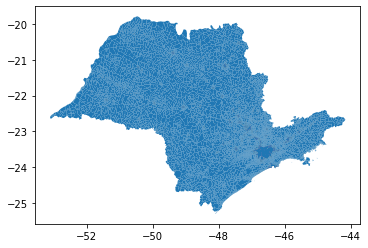

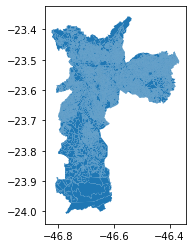

In [3]:
########IMPORTING INCOME SETOR CENSITARIO
import basedosdados as bd
              
# Uploading setor censitario data abour income
df_income = bd.read_table(dataset_id='br_ibge_censo_demografico', 
table_id='setor_censitario_domicilio_renda_2010',
billing_project_id="cyplan255", reauth=True)

df_income
#dicionário de dados: https://basedosdados.org/dataset/br-ibge-censo-demografico

#Reduzir base para o município de SP
SET_CEN_SP_income = df_income[df_income["sigla_uf"]== "SP1"]
SET_CEN_SP_income

#Total do rendimento nominal mensal dos domicílios particulares permanents - v003
#renaming v002 as income
SET_CEN_SP_income.rename(columns = {'v003':'total_income'}, inplace = True)
SET_CEN_SP_income


########IMPORTING HOUSEHOLDS SETOR CENSITARIO
import basedosdados as bd
              
# Uploading setor censitario data about domicilios
df_domicilios = bd.read_table(dataset_id='br_ibge_censo_demografico', 
table_id='setor_censitario_domicilio_caracteristicas_gerais_2010',
billing_project_id="cyplan255", reauth=True)
df_domicilios

#Reduzir base para o município de SP
SET_CEN_SP_domicilios = df_domicilios[df_domicilios["sigla_uf"]== "SP1"]
SET_CEN_SP_domicilios

#Domicílios particulares permanentes - v002
#renaming v002 as households
SET_CEN_SP_domicilios.rename(columns = {'v002':'total_domicilios'}, inplace = True)
SET_CEN_SP_domicilios

########## Importing shapefiles setor censitário#####

#import shapefile using geopandas
setor_censitario_SPS = gpd.read_file('data/sp_setores_censitarios/35SEE250GC_SIR.shp')
setor_censitario_SPS.plot()


#reducing to only sp municipality
setor_censitario_sp = setor_censitario_SPS[setor_censitario_SPS["NM_MUNICIP"]== "SÃO PAULO"]
setor_censitario_sp.plot()
setor_censitario_sp

#renaming column setor censitario
setor_censitario_sp.rename(columns = {'CD_GEOCODI':'id_setor_censitario'}, inplace = True)
setor_censitario_sp

#Merging with the income dataframe
setor_censitario_sp_income = setor_censitario_sp.merge(SET_CEN_SP_income, on='id_setor_censitario')
setor_censitario_sp_income 


#Merging with the domiciolios dataframe
setor_censitario_sp_inc_dom = setor_censitario_sp_income.merge(SET_CEN_SP_domicilios, on='id_setor_censitario')
setor_censitario_sp_inc_dom

#column names
list(setor_censitario_sp_inc_dom.columns)

#Creating a new column: household income (rendimento nominal medio mensal)
setor_censitario_sp_inc_dom["income_household"]= (setor_censitario_sp_inc_dom["total_income"]/setor_censitario_sp_inc_dom["total_domicilios"])
setor_censitario_sp_inc_dom

#investgating the columns
setor_censitario_sp_inc_dom["total_domicilios"].describe()

#replacing infinte values
setor_censitario_sp_inc_dom.replace([np.inf, -np.inf], np.nan, inplace=True)

#investgating the columns
setor_censitario_sp_inc_dom["income_household"].describe()

#list(setor_censitario_sp_inc_dom.columns)
setor_censitario_sp_inc_dom = setor_censitario_sp_inc_dom[['id_setor_censitario','NM_DISTRIT','geometry','income_household']]
setor_censitario_sp_inc_dom

#ordem decrescente
setor_censitario_sp_inc_dom.sort_values(by=['income_household'], ascending=False)



In [4]:
#fundurb_housing_geo
#uploading only valid geometries
fundurb_housing_geo_2 = pd.read_csv('fundurb_housing_geo_2.csv')  
fundurb_housing_geo_2


crs = {'init': 'epsg:4326'}

geometry = [Point(xy)for xy in zip (fundurb_housing_geo_2["longitude"], fundurb_housing_geo_2["latitude"])]
geometry[:3]

fundurb_housing_geo_2 = gpd.GeoDataFrame(fundurb_housing_geo_2, crs=crs, geometry=geometry)
fundurb_housing_geo_2

,ano,empreendimento,valor_pago,categoria,subcategoria,endereco,cod_distrito,ds_nome,cod_subprefeitura,subprefeitura,macroarea,category,percent,address,latitude,longitude,geometry
0,2015,MANUEL BUENO,4510807.00,Política de Habitação Social,Aquisição de imoveis,R MANUEL BUENO DA FONSECA,36,ITAIM PAULISTA,24,ITAIM PAULISTA,MACROÁREA DE ESTRUTURAÇÃO METROPOLITANA,Social Housing,0.002737,R MANUEL BUENO DA FONSECA - São Paulo,-23.493541,-46.389416,POINT (-46.38942 -23.49354)
1,2015,RESIDENCIAL JABUTICABEIRAS [FÓRUM DE CORTIÇOS ...,4000000.00,Política de Habitação Social,Produção de unidades habitacionais,"R JOÃO DA SILVA AGUIAR, 562",96,LAJEADO,28,GUAIANASES,MACROÁREA DE REDUÇÃO DA VULNERABILIDADE URBANA,Social Housing,0.002427,"R JOÃO DA SILVA AGUIAR, 562 - São Paulo",-23.535739,-46.398793,POINT (-46.39879 -23.53574)
2,2019,BENTO GUELFI,8582122.97,Política de Habitação Social,Aquisição de imoveis,"RUA BENTO GUELFI, 2860",33,IGUATEMI,30,SAO MATEUS,MACROÁREA DE REDUÇÃO DA VULNERABILIDADE URBANA...,Social Housing,0.005207,"RUA BENTO GUELFI, 2860 - São Paulo",-23.613322,-46.424014,POINT (-46.42401 -23.61332)
3,2019,JARDIM CONTINENTAL / PARQUE DAS FLORES,5614078.52,Política de Habitação Social,Urbanização de assentamentos precários,AVENIDA CIDADE DE MAUÁ,75,SAO RAFAEL,30,SAO MATEUS,MACROÁREA DE REDUÇÃO DA VULNERABILIDADE URBANA...,Social Housing,0.003406,AVENIDA CIDADE DE MAUÁ - São Paulo,-23.641964,-46.438373,POINT (-46.43837 -23.64196)
4,2019,JARDIM CONTINENTAL / PARQUE DAS FLORES,5614078.52,Política de Habitação Social,Urbanização de assentamentos precários,AVENIDA CIDADE DE MAUÁ,75,SAO RAFAEL,30,SAO MATEUS,MACROÁREA DE REDUÇÃO DA VULNERABILIDADE URBANA...,Social Housing,0.003406,AVENIDA CIDADE DE MAUÁ - São Paulo,-23.641964,-46.438373,POINT (-46.43837 -23.64196)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,2017,SÍTIO ITABERABA II,2215947.37,Política de Habitação Social,Urbanização de assentamentos precários,RUA DELSUC ALVES DE MAGALHÃES,3,ANHANGUERA,1,PERUS,MACROÁREA DE REDUÇÃO DA VULNERABILIDADE URBANA...,Social Housing,0.001344,RUA DELSUC ALVES DE MAGALHÃES - São Paulo,-23.435753,-46.787692,POINT (-46.78769 -23.43575)
243,2017,SÍTIO ITABERABA II,2215947.37,Política de Habitação Social,Urbanização de assentamentos precários,RUA DELSUC ALVES DE MAGALHÃES,3,ANHANGUERA,1,PERUS,MACROÁREA DE REDUÇÃO DA VULNERABILIDADE URBANA...,Social Housing,0.001344,RUA DELSUC ALVES DE MAGALHÃES - São Paulo,-23.435753,-46.787692,POINT (-46.78769 -23.43575)
244,2017,SÍTIO ITABERABA II,2215947.37,Política de Habitação Social,Urbanização de assentamentos precários,RUA DELSUC ALVES DE MAGALHÃES,3,ANHANGUERA,1,PERUS,MACROÁREA DE REDUÇÃO DA VULNERABILIDADE URBANA...,Social Housing,0.001344,RUA DELSUC ALVES DE MAGALHÃES - São Paulo,-23.435753,-46.787692,POINT (-46.78769 -23.43575)
245,2017,SÍTIO ITABERABA II,2215947.37,Política de Habitação Social,Urbanização de assentamentos precários,RUA DELSUC ALVES DE MAGALHÃES,3,ANHANGUERA,1,PERUS,MACROÁREA DE REDUÇÃO DA VULNERABILIDADE URBANA...,Social Housing,0.001344,RUA DELSUC ALVES DE MAGALHÃES - São Paulo,-23.435753,-46.787692,POINT (-46.78769 -23.43575)


In [ ]:
#PLOTTING THE MAP
sp_map = folium.Map(location=[-23.533773, -46.625290], zoom_start=11, tiles='Cartodb positron')

myscale = (setor_censitario_sp_inc_dom['income_household'].quantile((0,0.25,0.5,0.75,0.95,1))).tolist()

sp_map.choropleth(
 geo_data=setor_censitario_sp_inc_dom,
 name='Choropleth',
 data=setor_censitario_sp_inc_dom,
 columns=["id_setor_censitario", "income_household"],
 key_on="feature.properties.id_setor_censitario",
 fill_color='YlGnBu',
 fill_opacity=0.6,
 line_opacity=0.2,
 legend_name='Average income per household',
 smooth_factor=0,
 bins=[85,2500,5000,10000, 30000, 103319],
 nan_fill_color = "grey"
)

oodc_hab = [[point.xy[1][0], point.xy[0][0]] for point in fundurb_housing_geo_2.geometry]


plugins.MarkerCluster(oodc_hab).add_to(sp_map)

sp_map